<a href="https://colab.research.google.com/github/GustavoRT-debug/Sistemas-Embarcados-C213/blob/main/Trabalho_fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install scikit-fuzzy


In [12]:
pip install paho-mqtt

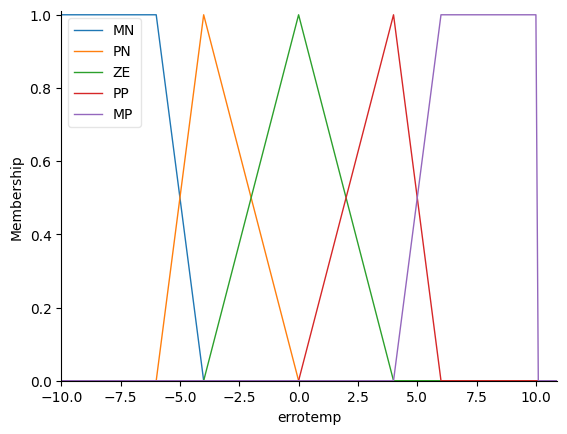

In [13]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client("c213Inatelsbm")
client.connect(mqttBroker)

# Universo e funções de pertinência para errotemp
errotemp = ctrl.Antecedent(np.arange(-10, 11, 0.1), 'errotemp')
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-10, -10, -6, -4])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-6, -4, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-4, 0, 4])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 4, 6])
errotemp['MP'] = fuzz.trapmf(errotemp.universe, [4, 6, 10, 10])
errotemp.view()

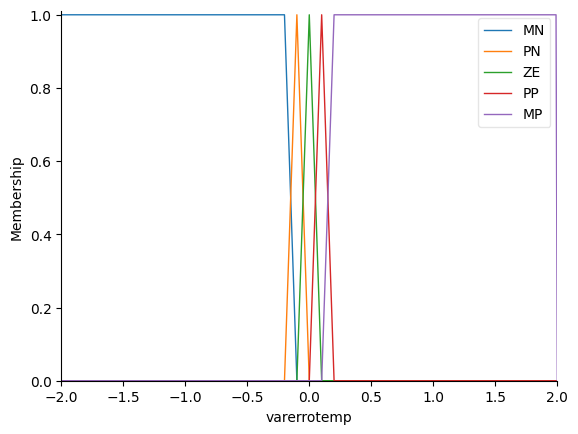

In [14]:
# Universo e funções de pertinência para varerrotemp
varerrotemp = ctrl.Antecedent(np.arange(-2, 2.01, 0.01), 'varerrotemp')
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2, -0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2, -0.1, 0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe, [0.1, 0.2, 2, 2])
varerrotemp.view()

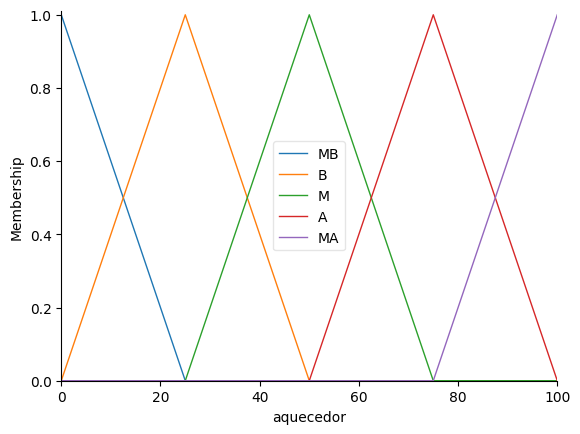

In [15]:
# Universo e funções de pertinência para aquecedor
aquecedor = ctrl.Consequent(np.arange(0, 101, 1), 'aquecedor')
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0, 0, 25])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0, 25, 50])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [25, 50, 75])
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [50, 75, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [75, 100, 100])
aquecedor.view()

In [16]:
regra1 = ctrl.Rule(errotemp['MN'] & varerrotemp['MN'], aquecedor['MB'])
regra2 = ctrl.Rule(errotemp['MN'] & varerrotemp['PN'], aquecedor['MB'])
regra3 = ctrl.Rule(errotemp['MN'] & varerrotemp['ZE'], aquecedor['MB'])
regra4 = ctrl.Rule(errotemp['PN'] & varerrotemp['MN'], aquecedor['MB'])
regra5 = ctrl.Rule(errotemp['PN'] & varerrotemp['PN'], aquecedor['B'])
regra6 = ctrl.Rule(errotemp['PN'] & varerrotemp['ZE'], aquecedor['B'])
regra7 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MN'], aquecedor['B'])
regra8 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PN'], aquecedor['M'])
regra9 = ctrl.Rule(errotemp['ZE'] & varerrotemp['ZE'], aquecedor['M'])
regra10 = ctrl.Rule(errotemp['PP'] & varerrotemp['MN'], aquecedor['M'])
regra11 = ctrl.Rule(errotemp['PP'] & varerrotemp['PN'], aquecedor['A'])
regra12 = ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], aquecedor['A'])
regra13 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['M'])
regra14 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['A'])
regra15 = ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], aquecedor['MA'])
regra16 = ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], aquecedor['A'])
regra17 = ctrl.Rule(errotemp['PP'] & varerrotemp['PP'], aquecedor['A'])
regra18 = ctrl.Rule(errotemp['PP'] & varerrotemp['MP'], aquecedor['MA'])
regra19 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['M'])
regra20 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['A'])
regra21 = ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], aquecedor['MA'])
regra22 = ctrl.Rule(errotemp['MP'] & varerrotemp['PP'], aquecedor['MA'])
regra23 = ctrl.Rule(errotemp['MP'] & varerrotemp['MP'], aquecedor['MA'])
regra24 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['M'])
regra25 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['A'])

In [17]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
controle = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [ ]:
# Parâmetros do Sistema
setpoint = 8
temp_atual = 10
print(temp_atual)
erro_anterior = 0

while True:
    controle.input['errotemp'] = erro_anterior
    erro_atual = temp_atual - setpoint
    var_erro_temp = erro_atual - erro_anterior

    controle.input['errotemp'] = erro_atual
    controle.input['varerrotemp'] = var_erro_temp
    controle.compute()

    # Simular mudança de temperatura
    i = 0
    while i < 10:
        temp_atual = temp_atual * 0.9952 - 0.0003963 * controle.output['aquecedor']
        time.sleep(1)
        i += 1

    print(f"Potência do resfriador: {controle.output['aquecedor']}%")
    print(f"Sensor de temperatura: {temp_atual} °C")

    # Publicar dados no MQTT
    client.publish("Aquecedor/Temperatura", temp_atual)
    client.publish("Aquecedor/erro", erro_atual)
    client.publish("Aquecedor/Potencia", controle.output['aquecedor'])

    # Lógica para diferentes modos de operação
    if setpoint == 2:
        print("Modo 1: Armazenamento de Vacinas - 2 °C")
    elif setpoint == 6:
        print("Modo 2: Temperatura de mantimento fora de operação - 6 °C")
    elif setpoint == 8:
        print("Modo 3: Armazenamento de Amostras Biológicas - 8 °C")

10
Potência do resfriador: 87.50000000000222%
Sensor de temperatura: 9.190868895788023 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 89.25225632075332%
Sensor de temperatura: 8.412951724627261 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 88.13353063919797%
Sensor de temperatura: 7.675917232308937 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 24.919448108075954%
Sensor de temperatura: 7.218680855400032 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 24.543784553168056%
Sensor de temperatura: 6.784380784971087 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 23.908939106478588%
Sensor de temperatura: 6.372944790098331 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriador: 23.049423371139834%
Sensor de temperatura: 5.984170180243281 °C
Modo 3: Armazenamento de Amostras Biológicas - 8 °C
Potência do resfriad